<a href="https://colab.research.google.com/github/peterbmob/niteroi/blob/main/2024/Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2

In this example, we will perform a geometry optimisation and molecular dynamics of graphene using DFTB and the xTB parameterisation.

To perform a geometry optimization, we need to modify the Driver section of the dftb input

```
Driver = ConjugateGradient{ #THE "Driver" BLOCK CONTROLS GEOMETRY OPTIMIZATION
   MaxForceComponent = 0.0001
   MaxSteps = 100
   LatticeOpt = Yes
   Isotropic = Yes
   }
```


In [1]:
#@title Create environment and install required software
# Conda is uninstalled every time you rehash yuor environment...
#!conda --version
#If !conda --version returns no results, install conda with :
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [2]:
%%capture
!conda install -c conda-forge mamba dftbplus
!conda install -c conda-forge dftbplus-tools
!conda install -c conda-forge ase
!conda install -c conda-forge py3dmol

In [35]:
import ase.build

atoms = ase.build.graphene(formula='C2', a=2.46, thickness=0.0, size=(3, 3, 1), vacuum=10)
write("in.gen",atoms)

In [51]:
#THE MAIN INPUT FILE FOR DFTB+ CODE IS dftb_in.hsd.
#THE CODE BELOW SHOW HOW TO WRITE SUCH A FILE.
dftb_in='''
Geometry = GenFormat {
    <<< "in.gen" #The file containing the geometry of the system
}

Driver = GeometryOptimisation{ #THE "Driver" BLOCK CONTROLS GEOMETRY OPTIMIZATION
   Optimizer = Rational {}
   MovedAtoms = 1:-1
   MaxSteps = 100
   LatticeOpt = Yes
   Isotropic = Yes
   Convergence {GradElem = 1E-4}
   }

Hamiltonian = xTB{ #THE "Hamiltonian" BLOCK GIVE SETTING FOR THE ELECTRONICS
   Method = "GFN1-xTB"
   KPointsAndWeights = SupercellFolding {
      7 0 0
      0 7 0
      0 0 1
      0.0 0.0 0.0
   }
   SCC = Yes
   SCCTolerance = 1e-05 # SelfConsistentField convergence criterium.
   Mixer = Broyden {
       MixingParameter = 0.02
   }
   Filling = Fermi {
       Temperature [Kelvin] = 300
   }
   }
Options {
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}

ParserOptions {
   IgnoreUnprocessedNodes = Yes
}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

In [52]:
!dftb+ > std.out

In [53]:
from ase.visualize import view

atoms = read('geo_end.gen')
atoms=atoms
view(atoms, viewer='x3d')

In [54]:
!dp_dos band.out dos.dat

In [55]:
!grep Fermi detailed.out

 Fermi distribution function
Fermi level:                        -0.3693208246 H          -10.0497 eV


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


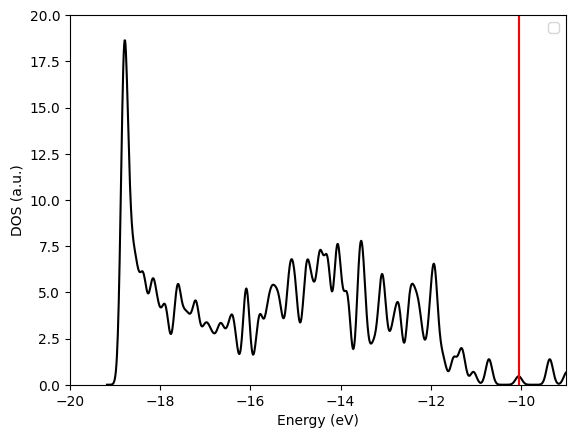

In [56]:
import numpy as np
import matplotlib.pyplot as plt

dos_tot=np.loadtxt("dos.dat")


plt.plot(dos_tot[:,0],dos_tot[:,1],color="black")

plt.xlabel("Energy (eV)")
plt.ylabel("DOS (a.u.)")
plt.axis([-20, -9, 0, 20])
plt.vlines(x=-10.0497,ymin=0,ymax=20,color="red")
plt.legend()
plt.show()

# MD with DFTB+

To perform Molecular Dynamics with the DFTB+ code, you change the Driver snippet to:

```
Driver = VelocityVerlet{
  TimeStep [fs] = 1.0
  Thermostat = NoseHoover {
    Temperature [Kelvin] = 400
    CouplingStrength [cm^-1] = 3200
  }
  Steps = 20000
  MovedAtoms = 1:-1
  MDRestartFrequency = 100
}

```

To speed up the SCC, we add additional keywords in the Driver section:

```
  XlbomdFast {
    IntegrationSteps = 5
    Scale = 0.5
    TransientSteps = 10
  }

```

This leads to worce forces, so we also need to add the following snippet to the Hamiltonian:

```
ForceEvaluation = Dynamics
```


In [61]:
#THE MAIN INPUT FILE FOR DFTB+ CODE IS dftb_in.hsd.
#THE CODE BELOW SHOW HOW TO WRITE SUCH A FILE.
dftb_in='''
Geometry = GenFormat {
    <<< "geo_end.gen" #The file containing the geometry of the system
}

Driver = VelocityVerlet{
  TimeStep [fs] = 1.0
  Thermostat = NoseHoover {
    Temperature [Kelvin] = 400
    CouplingStrength [cm^-1] = 3200
  }
  Steps = 1000
  MovedAtoms = 1:-1
  MDRestartFrequency = 1
  XlbomdFast {
    IntegrationSteps = 5
    Scale = 0.5
    TransientSteps = 10
}
}

Hamiltonian = xTB{ #THE "Hamiltonian" BLOCK GIVE SETTING FOR THE ELECTRONICS
   Method = "GFN1-xTB"
   KPointsAndWeights = SupercellFolding {
      3 0 0
      0 3 0
      0 0 1
      0.0 0.0 0.0
   }
   SCC = Yes
   SCCTolerance = 1e-05 # SelfConsistentField convergence criterium.
   Mixer = Broyden {
       MixingParameter = 0.02
   }
   ForceEvaluation = Dynamics
   Filling = Fermi {
       Temperature [Kelvin] = 300
   }
   }
Options {
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}

ParserOptions {
   IgnoreUnprocessedNodes = Yes
}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

In [62]:
!dftb+ > std.out

The output from the MD is written to md.out and the trajectory file is in geo_end.xyz

More examples of graphene calculations can be found at https://dftbplus-recipes.readthedocs.io/en/latest/defect/carbon2d-elec.html


How to build nanoribbons using ASE can be found here https://wiki.fysik.dtu.dk/ase/ase/build/build.html#graphene-nanoribbons

## Task: plot the dos for a hydrogen saturated carbon zigzag nanoribbon

# Reading any structure with ASE

With ase you can read in principle any structure format and write the resulting atoms object to a dftb+ input using the following snippet:

```
from ase.io import read, write

atoms = read('structure.cif')
write("in.gen",atoms)
```

Task: perform a geometry optimization using DFTB+ for a structure of your own.